In [9]:
import sys
sys.path.append("..")
from flame_analysis_model import *
import keras
import torch
from keras import layers
from keras.datasets import mnist, fashion_mnist
import numpy as np
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [11]:
df = pd.read_csv("flame_front_po_post0.csv")
print(df.keys())
# Select meaningful physical variables
features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]

X = StandardScaler().fit_transform(df[features])
c = X[:, 5]

Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'omega_H2',
       'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH', 'omega_HO2',
       'omega_H2O2', 'omega_N2', 'Le_def'],
      dtype='object')


In [12]:
num_points, num_input = X.shape
num_latent = 5
num_hidden = 30

learning_rate = 5e-03
batch_size = 200
num_epochs = 5000

# Convert the training data to PyTorch tensors
X_train = torch.from_numpy(X).to(device).float()

# Create the autoencoder model and optimizer
model = VAE(num_input, num_hidden, num_latent)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss(reduction="mean")

# Set the device to GPU if available, otherwise use CPU
model.to(device)

# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=True
)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        data = data.to(device)

        # Forward pass
        encoded, decoded, mu, log_var = model(data)

        # Compute the loss and perform backpropagation
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = criterion(decoded, data) + KLD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )



Epoch 1/5000: loss=231.0409
Epoch 2/5000: loss=41.1242
Epoch 3/5000: loss=15.5555
Epoch 4/5000: loss=9.5161
Epoch 5/5000: loss=6.2381
Epoch 6/5000: loss=4.0158
Epoch 7/5000: loss=2.6722
Epoch 8/5000: loss=1.9973
Epoch 9/5000: loss=1.6191
Epoch 10/5000: loss=1.4141
Epoch 11/5000: loss=1.3030
Epoch 12/5000: loss=1.2376
Epoch 13/5000: loss=1.1992
Epoch 14/5000: loss=1.1734
Epoch 15/5000: loss=1.1549
Epoch 16/5000: loss=1.1407
Epoch 17/5000: loss=1.1283
Epoch 18/5000: loss=1.1195
Epoch 19/5000: loss=1.1090
Epoch 20/5000: loss=1.1017
Epoch 21/5000: loss=1.0948
Epoch 22/5000: loss=1.0891
Epoch 23/5000: loss=1.0846
Epoch 24/5000: loss=1.0783
Epoch 25/5000: loss=1.0735
Epoch 26/5000: loss=1.0695
Epoch 27/5000: loss=1.0659
Epoch 28/5000: loss=1.0621
Epoch 29/5000: loss=1.0593
Epoch 30/5000: loss=1.0555
Epoch 31/5000: loss=1.0517
Epoch 32/5000: loss=1.0505
Epoch 33/5000: loss=1.0468
Epoch 34/5000: loss=1.0428
Epoch 35/5000: loss=1.0422
Epoch 36/5000: loss=1.0405
Epoch 37/5000: loss=1.0382
Epoch 

KeyboardInterrupt: 

In [13]:
# Put model in evaluation mode
model.eval()

# Convert data to tensor
X_torch = torch.from_numpy(X).float().to(device)

# Forward pass (no gradient)
with torch.no_grad():
    encoded, decoded, mu, log_var = model(X_torch)

# Move back to CPU and NumPy
decoded_np = decoded.cpu().numpy()
mu_np = mu.cpu().numpy()        # latent means
X_np = X_torch.cpu().numpy()


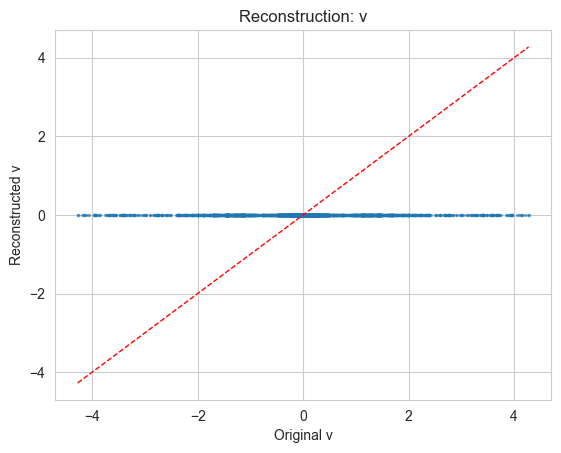

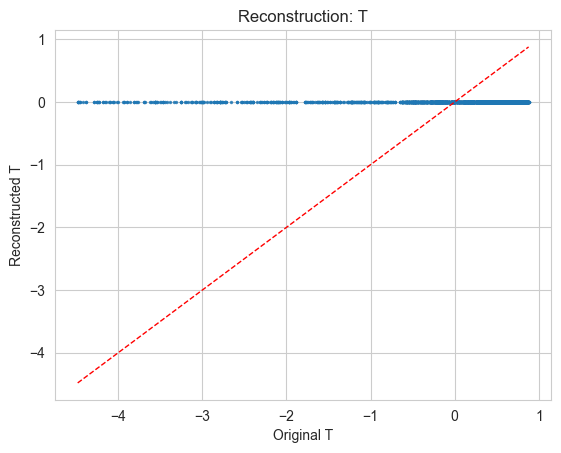

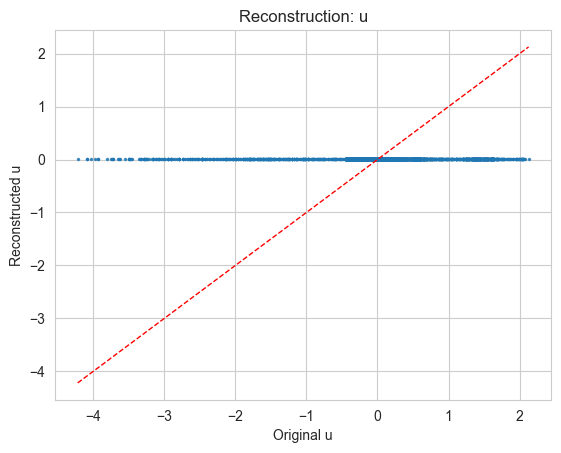

In [14]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = ['v','T','u','dudx','dudy','dvdx','dvdy','H2','O2','H2O','H','O','OH','HO2','H2O2']

for i in range(3):  # pick a few features
    plt.figure()
    plt.scatter(X_np[:, i], decoded_np[:, i], s=2, alpha=0.5)
    plt.xlabel(f'Original {feature_names[i]}')
    plt.ylabel(f'Reconstructed {feature_names[i]}')
    plt.title(f'Reconstruction: {feature_names[i]}')
    plt.plot([X_np[:, i].min(), X_np[:, i].max()],
             [X_np[:, i].min(), X_np[:, i].max()],
             'r--', lw=1)
    plt.grid(True)
plt.show()


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


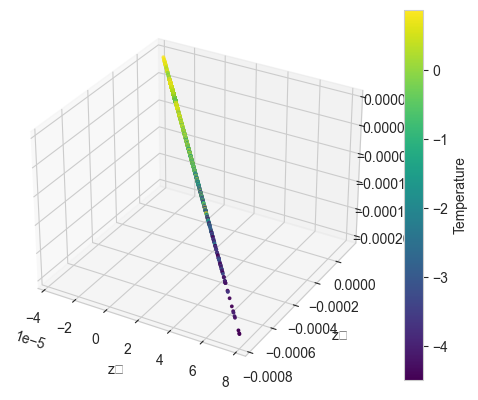

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(mu_np[:,0], mu_np[:,1], mu_np[:,2], c=X_np[:,1], cmap='viridis', s=3)
ax.set_xlabel('z₁')
ax.set_ylabel('z₂')
ax.set_zlabel('z₃')
fig.colorbar(p, label='Temperature')
plt.show()
